<a href="https://colab.research.google.com/github/xanasa14/MLImplementations/blob/master/ToxicComments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [ ]:
toxic_comments = pd.read_csv("/content/train.csv",engine='python',encoding='utf-8')
print(toxic_comments.head())

                 id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]


In [ ]:
print(toxic_comments['comment_text'].head())
print(toxic_comments.shape)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object
(159571, 8)


In [ ]:
filter = toxic_comments["comment_text"] != ""
toxic_comments = toxic_comments[filter]
toxic_comments = toxic_comments.dropna()
print(toxic_comments["comment_text"][168])


You should be fired, you're a moronic wimp who is too lazy to do research. It makes me sick that people like you exist in this world.


In [ ]:
print("Toxic:" + str(toxic_comments["toxic"][168]))
print("Severe_toxic:" + str(toxic_comments["severe_toxic"][168]))
print("Obscene:" + str(toxic_comments["obscene"][168]))
print("Threat:" + str(toxic_comments["threat"][168]))
print("Insult:" + str(toxic_comments["insult"][168]))
print("Identity_hate:" + str(toxic_comments["identity_hate"][168]))

Toxic:1
Severe_toxic:0
Obscene:0
Threat:0
Insult:1
Identity_hate:0


In [ ]:
toxic_comments_labels = toxic_comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


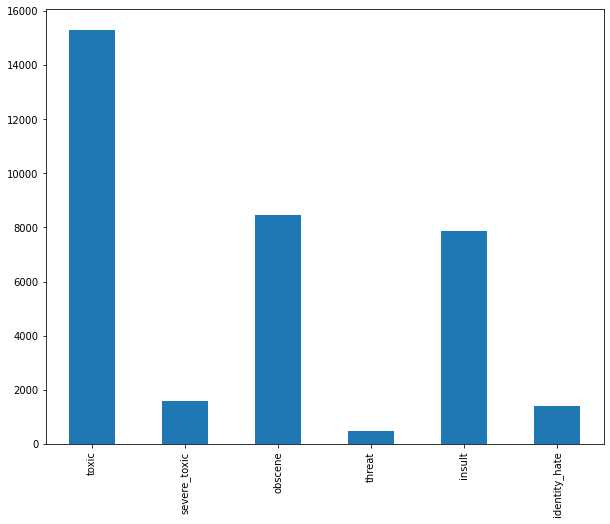

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [ ]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
X = []
sentences = list(toxic_comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

#glove_file = open('/content/drive/My Drive/Colab Datasets/glove.6B.100d.txt', encoding="utf8")
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [ ]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
print(model.summary())


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=1, verbose=1, validation_split=0.2)

798/798 [==============================] - 520s 649ms/step - loss: 0.1788 - acc: 0.8787 - val_loss: 0.1418 - val_acc: 0.9902


In [39]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

998/998 [==============================] - 59s 59ms/step - loss: 0.1141 - acc: 0.9941
Test Score: 0.11413722485303879
Test Accuracy: 0.9940780401229858


In [ ]:
#/content/drive/MyDrive/toxicCommentz
#model.save('/content/drive/MyDrive/toxicCommentz/my_model.h5')
# LOAD 
import keras
model = keras.models.load_model('/content/drive/MyDrive/toxicCommentz/my_model.h5')

y_test = model.predict(X_train)

In [ ]:
import sklearn.metrics as metrics

matrix = metrics.confusion_matrix(y_pred.argmax(axis=1), y_test.argmax(axis=1))


In [50]:
matrix

array([[31726,   101,     1,    76,    10],
       [    0,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0],
       [    1,     0,     0,     0,     0],
       [    0,     0,     0,     0,     0]])